# MLP and GCN on Cora

In this notebook, we'll build our first **Graph Neural Networks (GNNs)** using **PyTorch**.

We will:

1. Install and import the required Python packages (`numpy`, `torch`, and `torch_geometric`).
2. Load the **Cora** citation network dataset.
3. Understand the **node classification** task.
4. Build and train a **Multy Layer Perceptron (MLP)**.
5. Build and train a **Graph Neural Network (GNN)**.
6. Plot and interpret the training loss, and compute accuracy.
7. Build a more advanced GNN: **Graph Convolutional Network (GCN)**
8. Compare the loss curves and accuracy of MLP vs GCN.



## 1. Install libraries and import modules

We will use:

- **torch**, perhaps the most popular tool out there, for tensors, automatic differentiation, and neural networks.
- **torch_geometric** (PyTorch Geometric) to easily work with graph data and layers like **GCN** and **GraphSAGE**.

> Note: The `pip install` command is designed for Google Colab. If you're running locally, you may need to adjust versions according to your PyTorch installation.


In [ ]:
# If running in Google Colab, uncomment and run this cell once to install PyTorch Geometric.
# It may take a minute and might show some warnings.

!pip install -q torch
!pip install -q torch_geometric torch_sparse torch_scatter torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html || echo "If this fails, check https://pytorch-geometric.readthedocs.io/en/latest/notes/installation.html for updated install instructions."



We import tools for working with graph data and GNN layers. `Planetoid` loads benchmark graph datasets like `Cora`, and `GCNConv` / `SAGEConv`
 provide common graph neural network layers. We also print the PyTorch version and choose whether to use a GPU or CPU for training, depending on what’s available.

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

import matplotlib.pyplot as plt

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv, SAGEConv

print("PyTorch version:", torch.__version__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


PyTorch version: 2.9.0+cu126
Using device: cpu


Most likely you will see ``Using device: cpu`` which works fine for this lab. However, if you would like to run your lab on GPU go to Runtime → Change runtime type → Hardware accelerator → GPU



## 2. Load the Cora dataset

We will use the **Cora citation network** from the `Planetoid` benchmark datasets (provided by `torch_geometric`).

- Each **node** is a paper.
- Each **edge** is a citation link between two papers.
- Each node has a **feature vector** (bag-of-words of the paper).
- Each node has a **label** (which research topic the paper belongs to).

The task is **node classification**: given the graph structure and node features, predict the topic of each paper.

We can do node classfication (calssification of papers based on their topic) uisng models that ignore the citations, for instance we will do this using an MLP. We will see later that capturing the structure of the data i.e. the graph, improves the accuarcy substantially.

In [ ]:
# Download and load the Cora dataset
dataset = Planetoid(root="data/Cora", name="Cora")

print(dataset)
print("Number of graphs:", len(dataset))
print("Number of node features:", dataset.num_node_features)
print("Number of classes:", dataset.num_classes)

data = dataset[0]  # Cora contains a single graph
print(data)


Cora()
Number of graphs: 1
Number of node features: 1433
Number of classes: 7
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


Note that this dataset conatains only one graph over which we perform node classification. Cora has 2708 nodes, each node with 1433 features, 10556 edges, and predefined train/val/test masks.

We move this data to the chosen device (CPU or GPU) so it matches the model’s device. Printing the shapes helps us understand the graph structure:

In [ ]:
# Move data to the chosen device (CPU or GPU)
data = data.to(device)

print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.edge_index.size(1))
print("Training nodes:", int(data.train_mask.sum()))
print("Validation nodes:", int(data.val_mask.sum()))
print("Test nodes:", int(data.test_mask.sum()))


Number of nodes: 2708
Number of edges: 10556
Training nodes: 140
Validation nodes: 500
Test nodes: 1000


Noticed something strange about these numbers?

The training, validation, and test splits do not cover all 2708 nodes. In the original Planetoid dataset, only 140 nodes are used for training, 500 for validation, and 1000 for testing, leaving the remaining nodes unlabeled. These unlabeled nodes are still part of the graph and contribute through their features and connections during message passing. This kind of classification tasks over partially labled data are called **semi-supervised**.

## 3. Very quick PyTorch primer

PyTorch key ideas:

- A tensor is like a NumPy array but can live on a GPU and supports automatic differentiation.
- A model is usually a class that inherits from `torch.nn.Module` and defines a `forward` method.
- We compute a loss, then call `loss.backward()` to compute gradients, and use an optimizer (like Adam) to update parameters.

## 4. Baseline model: MLP without graph structure

Before using GNNs, let's build a simple **MLP (Multi-Layer Perceptron)** that:

- Uses only the node features `x`
- Completely ignores the edges `edge_index`

This is like training a normal neural network on a table of data and pretending there is no graph.  
By comparing this to GCN, we can see how much the graph structure helps.


In [ ]:

class MLP(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        # First linear fully connected layer. It transforms each node’s feature vector from size `in_channels` to size `hidden_channels`.
        self.lin1 = nn.Linear(in_channels, hidden_channels)

        # Second layer, Second linear layer. This produces the final class scores for each node.
        self.lin2 = nn.Linear(hidden_channels, out_channels)

        # Dropout rate (a form of regularization to prevent overfitting).
        self.dropout = dropout


    # Defines how data flows through the network.
    def forward(self, x):
        # No edge_index here: this model completely ignores the graph!
        x = self.lin1(x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training) # this will be deactivated during evaluation.
        x = self.lin2(x)
        return x


mlp_model = MLP(
    in_channels=dataset.num_node_features,  # In Cora, each node (paper) has 1433 features, so the input layer must match that size.
    hidden_channels=16, # This sets the number of neurons in the hidden layer.
    out_channels=dataset.num_classes, # The number of output units equals the number of classes (7 for Cora)
    dropout=0.5,
).to(device)

mlp_criterion = nn.CrossEntropyLoss()
mlp_optimizer = Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

def train_mlp(num_epochs=200):
    mlp_model.train()
    losses = []

    for epoch in range(1, num_epochs + 1):

        #Clear any previously stored gradients.
        mlp_optimizer.zero_grad()

        # Forward pass: predictions for all nodes, using only features
        out = mlp_model(data.x)

        # Compute loss only on training nodes
        loss = mlp_criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()
        mlp_optimizer.step() # Adam optimizer updates the model’s parameters using the gradients.

        losses.append(loss.item())

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | MLP training loss: {loss.item():.4f}")

    return losses

mlp_train_losses = train_mlp(num_epochs=200)


Epoch   1 | MLP training loss: 1.9491
Epoch  20 | MLP training loss: 0.6343
Epoch  40 | MLP training loss: 0.1977
Epoch  60 | MLP training loss: 0.2489
Epoch  80 | MLP training loss: 0.2639
Epoch 100 | MLP training loss: 0.2263
Epoch 120 | MLP training loss: 0.2312
Epoch 140 | MLP training loss: 0.1662
Epoch 160 | MLP training loss: 0.2164
Epoch 180 | MLP training loss: 0.2130
Epoch 200 | MLP training loss: 0.1408


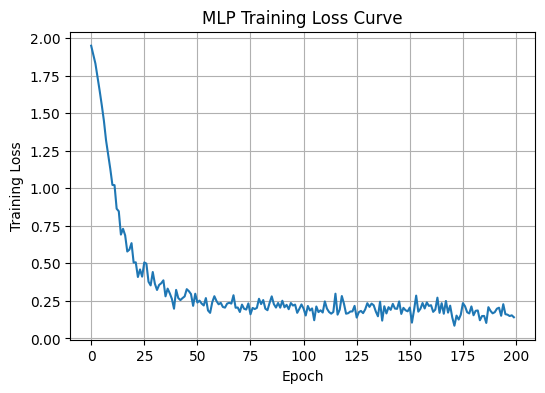

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(mlp_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("MLP Training Loss Curve")
plt.grid(True)
plt.show()

The loss appears to go done and plateau after 60 epochs. Let's evaluate the trained model on the train, evaluation, and test sets.

In [ ]:
@torch.no_grad()
def evaluate_mlp(model, data):
    model.eval()
    out = model(data.x)
    pred = out.argmax(dim=1)

    accs = {}
    for split, mask in [("train", data.train_mask), ("val", data.val_mask), ("test", data.test_mask)]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs[split] = acc
    return accs

mlp_accs = evaluate_mlp(mlp_model, data)
print("MLP accuracy (no graph):")
for split, acc in mlp_accs.items():
    print(f"  {split:>5}: {acc:.4f}")


MLP accuracy (no graph):
  train: 1.0000
    val: 0.4900
   test: 0.4890


We see that over the train set we have perfect classification. However, for the test set the model is performing very bad. This is due to overfitting. Recall that the size of training set is only 140 which is very small even for our 2layer MLP with 16 hidden channels.

## 5. Build a simple GNN for node classification

### What does a GNN do?

A **Graph Neural Network (GNN)** updates each node's representation by combining:

1. Its own features.
2. The features of its neighbors in the graph.

More specifically, each node updates its representation by looking at all its neighbors (including itself), applying a weight matrix, and aggregating these messages.

Each node updates its features by simply summing the features of its neighbors (including itself) and then applying a learnable weight matrix. This is the **unnormalized** version of the extremely polpular **Graph Convoluiotnal Network (GCN)** layer.

The update for node $i$ is

$$
h_i^{(l+1)} = \sigma\!\left(
    \sum_{j \in \mathcal{N}(i) \cup \{i\}}
    h_j^{(l)} W^{(l)}
\right),
$$

where $h_j^{(l)}$ is the feature vector (also known as hidden representation) of node $j$ at layer $l$, $W^{(l)}$ is the learnable weight matrix, and $\sigma$ is a non-linearity such as ReLU.

To express this operation for **all nodes at once**, we build the adjacency matrix with self-loops:

$$
\tilde{A} = A + I,
$$

where each entry $\tilde{A}_{ij} = 1$ if there is an edge (or self-loop) between nodes $i$ and $j$, and $0$ otherwise.

If we stack all node features into a matrix $H^{(l)}$ (each row is $h_i^{(l)}$), then summing neighbor features becomes the matrix multiplication

$$
\tilde{A} \, H^{(l)}.
$$

After aggregation, we apply the weight matrix:

$$
\tilde{A} \, H^{(l)} \, W^{(l)}.
$$

Finally, applying the non-linearity gives the matrix form of the next GCN layer:

$$
H^{(l+1)} = \sigma\!\left( \tilde{A} \, H^{(l)} \, W^{(l)} \right).
$$

Thus, the compact matrix expression is simply another way of writing the same neighbor-summing update rule, but applied to all nodes simultaneously.


Let's write a code that computes the matrix $\tilde A$, from the adjacency matrix.

In [ ]:
from torch_geometric.utils import add_self_loops, degree

def build_unnormalized_adj(edge_index, num_nodes, device):
    """
    Build a dense adjacency matrix A_tilde = A + I
    without any degree normalization.
    """
    # Add self-loops
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)

    row, col = edge_index
    A_tilde = torch.zeros((num_nodes, num_nodes), device=device)
    A_tilde[row, col] = 1.0   # 1 if there is an edge (or self-loop), else 0

    return A_tilde
A_tilde = build_unnormalized_adj(data.edge_index, data.num_nodes, device)


Next, we are going to build a 2 layer GNN similar to the MLP we built earlier, but this time we are going to chnage the forward pass to account for the updates of GNN and aggeregations.

In [ ]:
class ManualGCNNoNorm(nn.Module):
    """
    A simple 2-layer GCN that just sums neighbor features
    (with self-loops) with no normalization.
    """
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        # These are W^(0) and W^(1) in the formula
        self.lin1 = nn.Linear(in_channels, hidden_channels, bias=False)
        self.lin2 = nn.Linear(hidden_channels, out_channels, bias=False)
        self.dropout = dropout

    def forward(self, x, A_tilde):
        # H^(0) = x

        # First layer:
        # h_i^{(1)} = σ( sum_{j in N(i)∪{i}} h_j^{(0)} W^(0) )

        # x = TODO .....


        # Second layer:
        # h_i^{(2)} = sum_{j in N(i)∪{i}} h_j^{(1)} W^(1)

        # x = TODO....

        # no softmax here; CrossEntropyLoss will take care of it
        x = self.lin1(x)
        x = torch.matmul(A_tilde, x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        x = self.lin2(x)
        x = torch.matmul(A_tilde, x)




        return x

Similar to the MLP, instantiate the model with 16 hidden_channels and dropout 0.5 and define the Cross Entropy loss and optimization. Use the same learning rate and weight decay.

In [ ]:
gcn_no_norm_model = ManualGCNNoNorm(
    # TODO ...
    in_channels=data.num_node_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    dropout=0.5,
).to(device)


# criterion = TODO
# optimizer = TODO

criterion = nn.CrossEntropyLoss()
optimizer = Adam(
    gcn_no_norm_model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

Write a train function for training the GNN and plot the losses.

In [ ]:
def train_gcn_no_norm(num_epochs=200):
    gcn_no_norm_model.train()
    losses = []
    for epoch in range(1, num_epochs + 1):

        # TODO
        optimizer.zero_grad()

        out = gcn_no_norm_model(data.x, A_tilde)

        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        loss.backward()

        optimizer.step()

        losses.append(loss.item())

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | GCN (no norm) loss: {loss.item():.4f}")

    return losses

# TODO: plot the losses

In [ ]:
gcn_no_norm_train_losses = train_gcn_no_norm(num_epochs=200)

Epoch   1 | GCN (no norm) loss: 2.0538
Epoch  20 | GCN (no norm) loss: 0.3330
Epoch  40 | GCN (no norm) loss: 0.1868
Epoch  60 | GCN (no norm) loss: 0.0883
Epoch  80 | GCN (no norm) loss: 0.1318
Epoch 100 | GCN (no norm) loss: 0.0715
Epoch 120 | GCN (no norm) loss: 0.0842
Epoch 140 | GCN (no norm) loss: 0.0476
Epoch 160 | GCN (no norm) loss: 0.0519
Epoch 180 | GCN (no norm) loss: 0.0392
Epoch 200 | GCN (no norm) loss: 0.0400


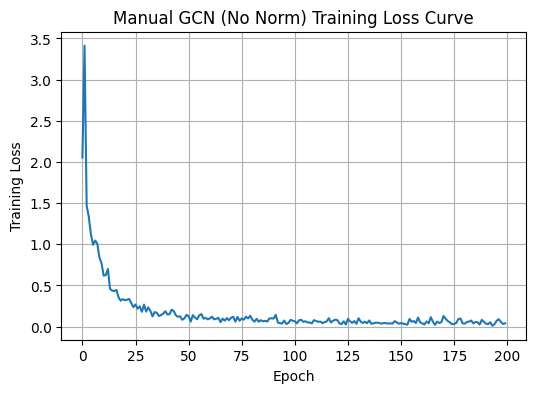

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(gcn_no_norm_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Manual GCN (No Norm) Training Loss Curve")
plt.grid(True)
plt.show()

Evalute the model on all the train, evaluation, and test datasets. You should see a significant improvment over the evaluation and test sets accuracy. You should see numbers around 0.70 to 0.75.

In [ ]:
@torch.no_grad()
def evaluate_gcn_no_norm(model, data, A_sum):

    # TODO
    model.eval()
    out = model(data.x, A_sum)
    pred = out.argmax(dim=1)

    accs = {}
    for split, mask in [("train", data.train_mask), ("val", data.val_mask), ("test", data.test_mask)]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs[split] = acc


    return accs

gcn_no_norm_losses = train_gcn_no_norm(num_epochs=200)

# gcn_no_norm_accs = TODO
gcn_no_norm_accs = evaluate_gcn_no_norm(gcn_no_norm_model, data, A_tilde)

print("GCN (no normalization) accuracy:")
for split, acc in gcn_no_norm_accs.items():
    print(f"  {split:>5}: {acc:.4f}")

Epoch   1 | GCN (no norm) loss: 0.0297
Epoch  20 | GCN (no norm) loss: 0.0414
Epoch  40 | GCN (no norm) loss: 0.0417
Epoch  60 | GCN (no norm) loss: 0.0343
Epoch  80 | GCN (no norm) loss: 0.0422
Epoch 100 | GCN (no norm) loss: 0.0273
Epoch 120 | GCN (no norm) loss: 0.0324
Epoch 140 | GCN (no norm) loss: 0.0182
Epoch 160 | GCN (no norm) loss: 0.0731
Epoch 180 | GCN (no norm) loss: 0.0216
Epoch 200 | GCN (no norm) loss: 0.0286
GCN (no normalization) accuracy:
  train: 1.0000
    val: 0.7280
   test: 0.7470


Despite the fact that we see no classification error over the train set, we observe a much better generalization to the test set.

## 6. Improved model using normalization

A drawback of what we implemented is that nodes with many neighbors get huge aggregated value and nodes with few neighbors get small aggregated value. This makes training unstable and hurts generalization.

This issue can be addressed using different tricks such as normalization and attenstion mechanisms. We will try the normalization method as in GCN developed by [Kipf and Welling](https://arxiv.org/pdf/1609.02907). For Graph Attenstion Networks see this [paper](https://arxiv.org/pdf/1710.10903).

<br>
For a single GCN layer, the normalized neighbor update for node \(i\) can be written as

$$
h_i^{(l+1)} = \sigma\!\left(
    \sum_{j \in \mathcal{N}(i) \cup \{i\}}
    \frac{1}{\sqrt{d_i d_j}} \, h_j^{(l)} W^{(l)}
\right),
$$

where $h_j^{(l)}$ is the feature vector of node $j$ at layer $l$, $W^{(l)}$ is a learnable weight matrix, $d_i$ and $d_j$ are node degrees (including self-loops), and $\sigma$ is a non-linearity such as ReLU.

To write this for **all nodes at once**, we first build:

- the adjacency matrix with self-loops $\tilde{A} = A + I$,
- the degree matrix $\tilde{D}$ with $\tilde{D}_{ii} = \sum_j \tilde{A}_{ij}$,
- the normalized matrix
$$
\hat{A} = \tilde{D}^{-1/2} \, \tilde{A} \, \tilde{D}^{-1/2}.
$$

The entry $\hat{A}_{ij}$ is exactly $\frac{1}{\sqrt{d_i d_j}}$ when there is an edge (or self-loop) between $i$ and $j$, and $0$ otherwise. If we stack all node features into a matrix $H^{(l)}$ (each row is $h_i^{(l)}$), then the node-wise summation becomes ordinary matrix multiplication:

$$
H^{(l+1)} = \sigma\!\big(\hat{A} \, H^{(l)} \, W^{(l)}\big).
$$

So the matrix form is just a compact way of writing the same normalized neighbor aggregation for every node simultaneously.


Write a code that computes $\hat A$

In [ ]:
from torch_geometric.utils import add_self_loops, degree

def build_normalized_adj(edge_index, num_nodes, device):
    # 1) Add self-loops
    # TODO
    edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes)
    row, col = edge_index


    # 2) Compute degree of each node
    # TODO
    deg = degree(col, num_nodes=num_nodes, dtype=torch.float)
    deg_inv_sqrt = deg.pow(-0.5)
    deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

    # 3) Compute D^{-1/2}
    # TODO
    D_inv_sqrt = torch.diag(deg_inv_sqrt)

    # 4) Build dense adjacency A_tilde
    # TODO
    A_tilde = torch.zeros((num_nodes, num_nodes), device=device)


    A_tilde[row, col] = 1.0

    # 5) A_hat = D^{-1/2} A_tilde D^{-1/2}
    # A_hat = TODO
    A_hat = torch.mm(torch.mm(D_inv_sqrt, A_tilde), D_inv_sqrt)

    return A_hat   # [N, N]

A_hat = build_normalized_adj(data.edge_index, data.num_nodes, device)

Similar to the way that we constructed unnormalized model, we can construct the normalized version. Use the same number of hidden channels, dropout, learning rate, and weight decay as before.

In [ ]:
class ManualGCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        # These are your W^(0) and W^(1)
        self.lin1 = nn.Linear(in_channels, hidden_channels, bias=False)
        self.lin2 = nn.Linear(hidden_channels, out_channels, bias=False)
        self.dropout = dropout

    def forward(self, x, A_hat):
        # H^(0) = x

        # First layer: H^(1) = σ( A_hat H^(0) W^(0) )
        # x = TODO ...
        x = self.lin1(x)
        x = torch.matmul(A_hat, x)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)


        # Second layer: H^(2) = A_hat H^(1) W^(1)
        # x = TODO ...
        x = self.lin2(x)
        x = torch.matmul(A_hat, x)

        # No softmax here: CrossEntropyLoss takes care of it
        return x


manual_gcn_model = ManualGCN(

    # TODO
    in_channels=data.num_node_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    dropout=0.5,

    ).to(device)

out = manual_gcn_model(data.x, A_hat)


# manual_gcn_criterion = TODO
# manual_gcn_optimizer =
manual_gcn_criterion = nn.CrossEntropyLoss()
manual_gcn_optimizer = Adam(
    manual_gcn_model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)

Werite the training function and plot the losses.

In [ ]:
def train_manual_gcn(num_epochs=200):
    manual_gcn_model.train()
    losses = []

    for epoch in range(1, num_epochs + 1):
        manual_gcn_optimizer.zero_grad()

        # Forward pass: use features + normalized adjacency
        # out = TODO ...
        out = manual_gcn_model(data.x, A_hat)

        # Compute loss only on training nodes
        # loss = TODO...
        loss = manual_gcn_criterion(out[data.train_mask], data.y[data.train_mask])


        # Backpropagation
        # TODO ...
        loss.backward()

        # Update weights
        # TODO
        manual_gcn_optimizer.step()

        losses.append(loss.item())

        if epoch == 1 or epoch % 20 == 0:
            print(f"Epoch {epoch:3d} | Manual GCN training loss: {loss.item():.4f}")

    return losses

manual_gcn_losses = train_manual_gcn(num_epochs=200)

# TODO... plot the losses


Epoch   1 | Manual GCN training loss: 1.9437
Epoch  20 | Manual GCN training loss: 0.5217
Epoch  40 | Manual GCN training loss: 0.1132
Epoch  60 | Manual GCN training loss: 0.0395
Epoch  80 | Manual GCN training loss: 0.0440
Epoch 100 | Manual GCN training loss: 0.0733
Epoch 120 | Manual GCN training loss: 0.0371
Epoch 140 | Manual GCN training loss: 0.0409
Epoch 160 | Manual GCN training loss: 0.0388
Epoch 180 | Manual GCN training loss: 0.0338
Epoch 200 | Manual GCN training loss: 0.0322


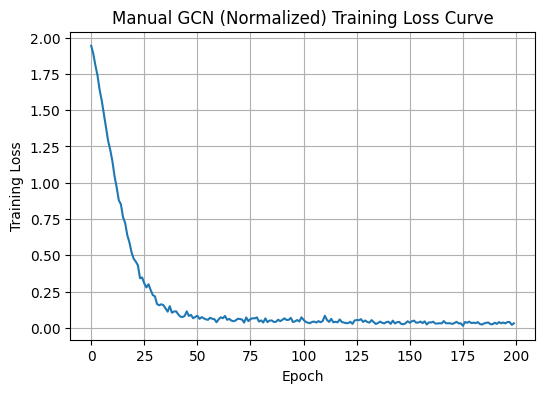

In [ ]:
plt.figure(figsize=(6,4))
plt.plot(manual_gcn_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Manual GCN (Normalized) Training Loss Curve")
plt.grid(True)
plt.show()

Evalute your trained model over the train, evaluation, and test data sets. You should see an improvment in the acurracies and it should be around 0.8.

In [ ]:
@torch.no_grad()
def evaluate_manual_gcn(model, data, A_hat):

    # TODO
    model.eval()
    out = model(data.x, A_hat)
    pred = out.argmax(dim=1)

    accs = {}
    for split, mask in [("train", data.train_mask), ("val", data.val_mask), ("test", data.test_mask)]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs[split] = acc

    return accs

    manual_gcn_losses = train_manual_gcn(num_epochs=200)

# manual_gcn_accs = TODO
manual_gcn_accs = evaluate_manual_gcn(manual_gcn_model, data, A_hat)

print("Manual GCN accuracy:")

for split, acc in manual_gcn_accs.items():
    print(f"  {split:>5}: {acc:.4f}")

Manual GCN accuracy:
  train: 1.0000
    val: 0.7620
   test: 0.7920


## 7. Let's compare our results with GCN from Torch Geomtric

We will use `GCNConv` from `torch_geometric.nn`, which implements the normalized sum aggeragtion for us.

 Use the same number of hidden channels, dropout, learning rate, and weight decay as before.

In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        # First graph convolution layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second graph convolution layer
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        # x: node features [num_nodes, in_channels]
        # edge_index: graph connectivity [2, num_edges]

        # 1st layer: GCNConv + ReLU
        # x = TODO
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)

        # 2nd layer: GCNConv
        # x = TODO
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p=self.dropout, training=self.training)
        # We do NOT apply softmax here because CrossEntropyLoss does it for us.
        return x


gcn_model = GCN(
    # TODO
    in_channels=data.num_node_features,
    hidden_channels=16,
    out_channels=dataset.num_classes,
    dropout=0.5,
).to(device)

print(gcn_model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


In [ ]:
# Define loss function and optimizer for GCN



# criterion = TODO ...
criterion = nn.CrossEntropyLoss()

# gcn_optimizer = TODO ...
gcn_optimizer = Adam(
    gcn_model.parameters(),
    lr=0.01,
    weight_decay=5e-4
)



def train_gcn(num_epochs=200):
    gcn_model.train()
    losses = []

    for epoch in range(1, num_epochs + 1):
        gcn_optimizer.zero_grad()

        # Forward pass: predictions for all nodes
        # out = TODO
        out = gcn_model(data.x, data.edge_index)

        # Compute loss only on training nodes
        # loss = TODO
        loss = criterion(out[data.train_mask], data.y[data.train_mask])

        # Backward pass: compute gradients
        # TODO
        loss.backward()

        # Update parameters
        # TODO
        gcn_optimizer.step()

        losses.append(loss.item())

        if epoch % 20 == 0 or epoch == 1:
            print(f"Epoch {epoch:3d} | GCN training loss: {loss.item():.4f}")

    return losses

gcn_train_losses = train_gcn(num_epochs=200)

Epoch   1 | GCN training loss: 1.9558
Epoch  20 | GCN training loss: 0.9332
Epoch  40 | GCN training loss: 0.7205
Epoch  60 | GCN training loss: 0.7586
Epoch  80 | GCN training loss: 0.7489
Epoch 100 | GCN training loss: 0.6901
Epoch 120 | GCN training loss: 0.6418
Epoch 140 | GCN training loss: 0.7005
Epoch 160 | GCN training loss: 0.7204
Epoch 180 | GCN training loss: 0.6902
Epoch 200 | GCN training loss: 0.7315


If running on CPU, you may notice that the training here is much faster than our implementations of GCN. On GPU the difference is not noticable.

Text(0.5, 1.0, 'GCN Training Loss Curve')

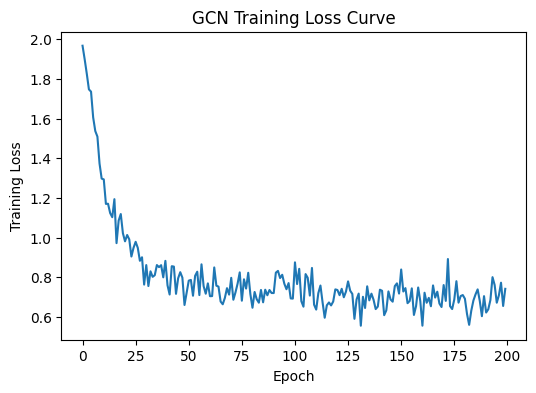

In [ ]:
# Plot GCN training loss
# TODO
plt.figure(figsize=(6,4))
plt.plot(gcn_train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("GCN Training Loss Curve")

In [ ]:
@torch.no_grad()
def evaluate(model, data):
    # TODO
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = {}
    for split, mask in [("train", data.train_mask), ("val", data.val_mask), ("test", data.test_mask)]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs[split] = acc
    return accs

# gcn_accs = TODO ...
gcn_accs = evaluate(gcn_model, data)

print("GCN accuracy:")
for split, acc in gcn_accs.items():
    print(f"  {split:>5}: {acc:.4f}")

GCN accuracy:
  train: 1.0000
    val: 0.7620
   test: 0.7970


You should see numbers similar to what obtained from out own model.

Finally, plot all the losses for all the 4 models you trained. You may observe that the normalized ones have smoother convergence and convergence to smaller loss.

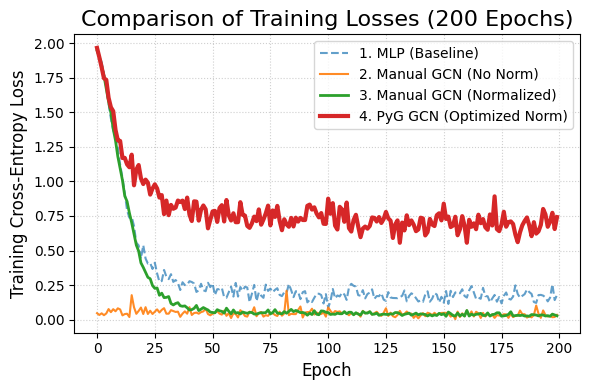

In [ ]:
# TODO
# Plot all the losses in one figure.

plt.figure(figsize=(6, 4))

plt.plot(mlp_train_losses, label='1. MLP (Baseline)', linestyle='--', alpha=0.7)
plt.plot(gcn_no_norm_losses, label='2. Manual GCN (No Norm)', alpha=0.9)
plt.plot(manual_gcn_losses, label='3. Manual GCN (Normalized)', linewidth=2)
plt.plot(gcn_train_losses, label='4. PyG GCN (Optimized Norm)', linewidth=3)

plt.title("Comparison of Training Losses (200 Epochs)", fontsize=16)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Training Cross-Entropy Loss", fontsize=12)

plt.legend(fontsize=10)
plt.grid(True, linestyle=':', alpha=0.6)

plt.tight_layout()
plt.show()